In [1]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.7 MB/s eta 0:00:00


In [2]:
# import necessory modules
import time
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
# import data
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/default+of+credit+card+clients.zip" -d "/content/drive/MyDrive/Credit_data/"

Mounted at /content/drive
Archive:  /content/drive/MyDrive/default+of+credit+card+clients.zip
replace /content/drive/MyDrive/Credit_data/default+of+credit+card+clients/default of credit card clients.xls? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
# read data
credit_data = pd.read_excel('/content/drive/MyDrive/Credit_data/default+of+credit+card+clients/default of credit card clients.xls')

In [5]:
# display the first few rows of the data
print(credit_data.head())

  Unnamed: 0         X1   X2         X3        X4   X5     X6     X7     X8  \
0         ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3   
1          1      20000    2          2         1   24      2      2     -1   
2          2     120000    2          2         2   26     -1      2      0   
3          3      90000    2          2         2   34      0      0      0   
4          4      50000    2          2         1   37      0      0      0   

      X9  ...        X15        X16        X17       X18       X19       X20  \
0  PAY_4  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3   
1     -1  ...          0          0          0         0       689         0   
2      0  ...       3272       3455       3261         0      1000      1000   
3      0  ...      14331      14948      15549      1518      1500      1000   
4      0  ...      28314      28959      29547      2000      2019      1200   

        X21       X22       X23             

In [6]:
# summary statistics of the data
print(credit_data.describe())

       Unnamed: 0     X1     X2     X3     X4     X5     X6     X7     X8  \
count       30001  30001  30001  30001  30001  30001  30001  30001  30001   
unique      30001     82      3      8      5     57     12     12     12   
top            ID  50000      2      2      2     29      0      0      0   
freq            1   3365  18112  14030  15964   1605  14737  15730  15764   

           X9  ...    X15    X16    X17    X18    X19    X20    X21    X22  \
count   30001  ...  30001  30001  30001  30001  30001  30001  30001  30001   
unique     12  ...  21549  21011  20605   7944   7900   7519   6938   6898   
top         0  ...      0      0      0      0      0      0      0      0   
freq    16455  ...   3195   3506   4020   5249   5396   5968   6408   6703   

          X23      Y  
count   30001  30001  
unique   6940      3  
top         0      0  
freq     7173  23364  

[4 rows x 25 columns]


In [7]:
# check for missing values
print(credit_data.isnull().sum())

Unnamed: 0    0
X1            0
X2            0
X3            0
X4            0
X5            0
X6            0
X7            0
X8            0
X9            0
X10           0
X11           0
X12           0
X13           0
X14           0
X15           0
X16           0
X17           0
X18           0
X19           0
X20           0
X21           0
X22           0
X23           0
Y             0
dtype: int64


In [8]:
# Set the first row as the column names
credit_data.columns = credit_data.iloc[0]
credit_data = credit_data[1:]

# Reset the index
credit_data.reset_index(drop=True, inplace=True)

# Display the first few rows to verify
print(credit_data.head())

0 ID LIMIT_BAL SEX EDUCATION MARRIAGE AGE PAY_0 PAY_2 PAY_3 PAY_4  ...  \
0  1     20000   2         2        1  24     2     2    -1    -1  ...   
1  2    120000   2         2        2  26    -1     2     0     0  ...   
2  3     90000   2         2        2  34     0     0     0     0  ...   
3  4     50000   2         2        1  37     0     0     0     0  ...   
4  5     50000   1         2        1  57    -1     0    -1     0  ...   

0 BILL_AMT4 BILL_AMT5 BILL_AMT6 PAY_AMT1 PAY_AMT2 PAY_AMT3 PAY_AMT4 PAY_AMT5  \
0         0         0         0        0      689        0        0        0   
1      3272      3455      3261        0     1000     1000     1000        0   
2     14331     14948     15549     1518     1500     1000     1000     1000   
3     28314     28959     29547     2000     2019     1200     1100     1069   
4     20940     19146     19131     2000    36681    10000     9000      689   

0 PAY_AMT6 default payment next month  
0        0                        

In [9]:
data = credit_data[['AGE', 'default payment next month']]

In [10]:
# Descriptive statistics for age based on default status
defaulted = data[data['default payment next month'] == 1]
not_defaulted = data[data['default payment next month'] == 0]

print("Defaulted Customers' Age Statistics")
print(defaulted['AGE'].describe())

print("\nNon-Defaulted Customers' Age Statistics")
print(not_defaulted['AGE'].describe())


Defaulted Customers' Age Statistics
count     6636
unique      53
top         27
freq       313
Name: AGE, dtype: int64

Non-Defaulted Customers' Age Statistics
count     23364
unique       56
top          29
freq       1292
Name: AGE, dtype: int64


In [11]:
# Calculate the frequency of each class
class_counts = credit_data['default payment next month'].value_counts()

# Display the frequency of each class
print(class_counts)


default payment next month
0    23364
1     6636
Name: count, dtype: int64


# **Exploratory** **Data** **Analysis**

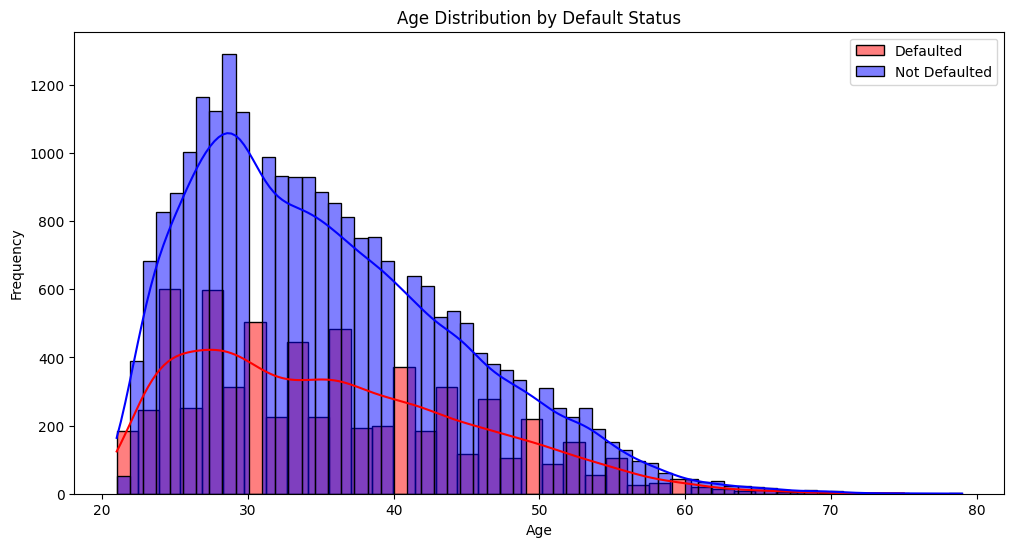

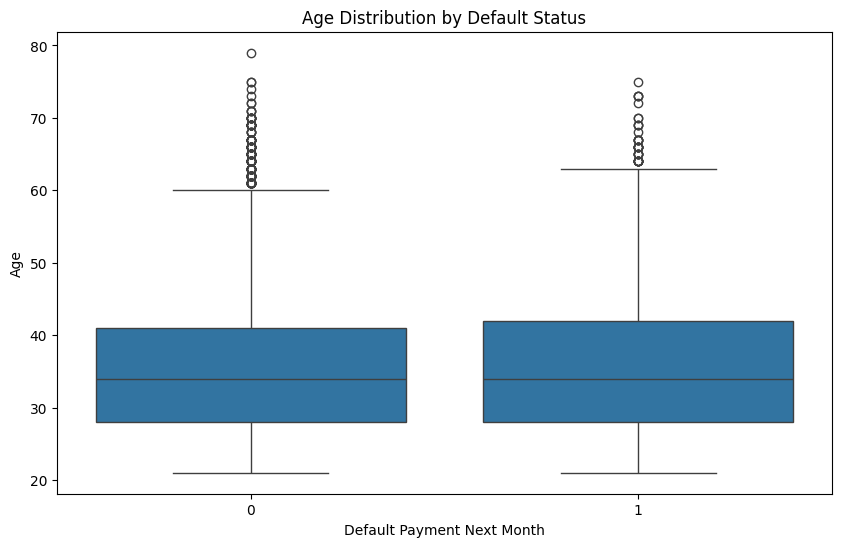

In [12]:
# Histogram of age for defaulted and non-defaulted customers
plt.figure(figsize=(12, 6))
sns.histplot(defaulted['AGE'], kde=True, color='red', label='Defaulted')
sns.histplot(not_defaulted['AGE'], kde=True, color='blue', label='Not Defaulted')
plt.legend()
plt.title('Age Distribution by Default Status')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Box plots
plt.figure(figsize=(10, 6))
sns.boxplot(x='default payment next month', y='AGE', data=data)
plt.title('Age Distribution by Default Status')
plt.xlabel('Default Payment Next Month')
plt.ylabel('Age')
plt.show()


<ipython-input-13-522947526984>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='default payment next month', data=data, palette=['blue', 'red'])


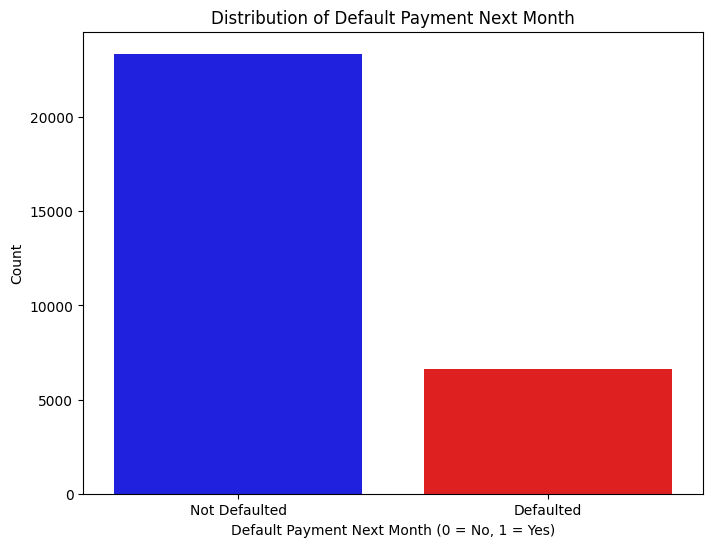

In [13]:
# Plotting the distribution of Default Payment Next Month
plt.figure(figsize=(8, 6))
sns.countplot(x='default payment next month', data=data, palette=['blue', 'red'])
plt.title('Distribution of Default Payment Next Month')
plt.xlabel('Default Payment Next Month (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Defaulted', 'Defaulted'])  # Adding labels for clarity
plt.show()

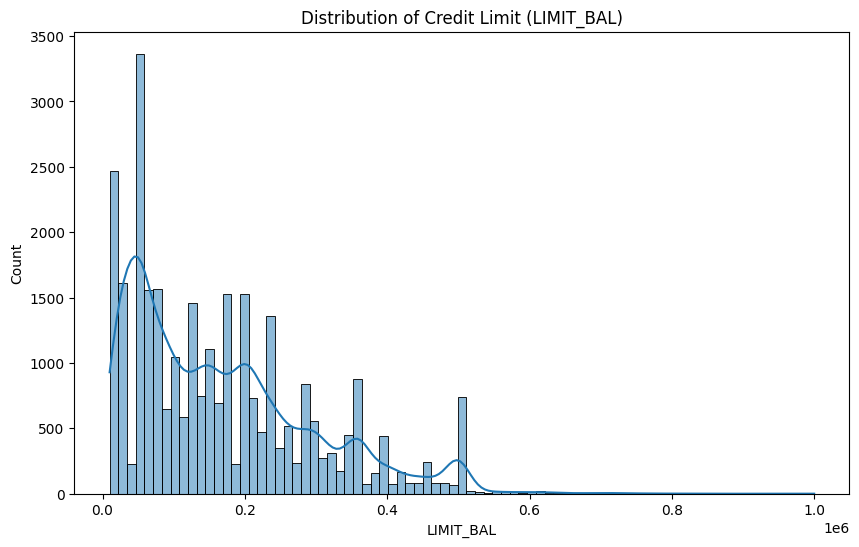

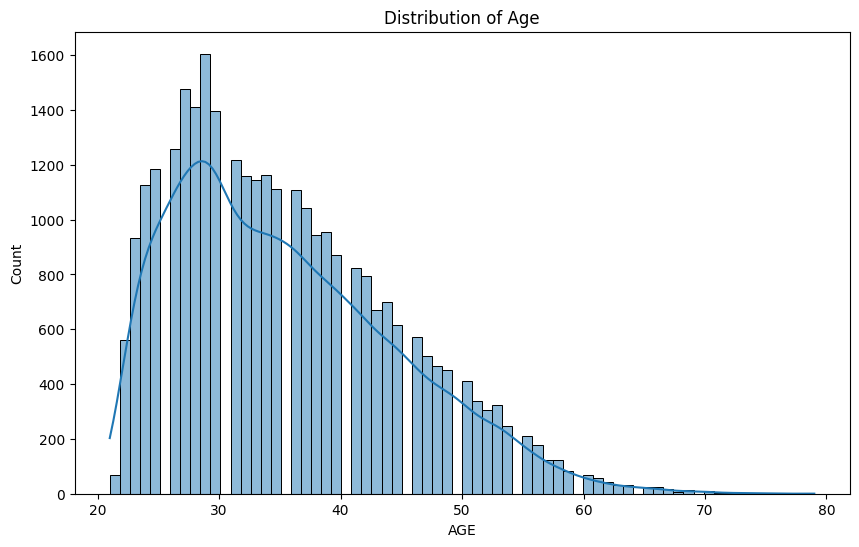

In [14]:
# Histogram for LIMIT_BAL
plt.figure(figsize=(10, 6))
sns.histplot(credit_data['LIMIT_BAL'], kde=True)
plt.title('Distribution of Credit Limit (LIMIT_BAL)')
plt.show()

# Histogram for AGE
plt.figure(figsize=(10, 6))
sns.histplot(credit_data['AGE'], kde=True)
plt.title('Distribution of Age')
plt.show()


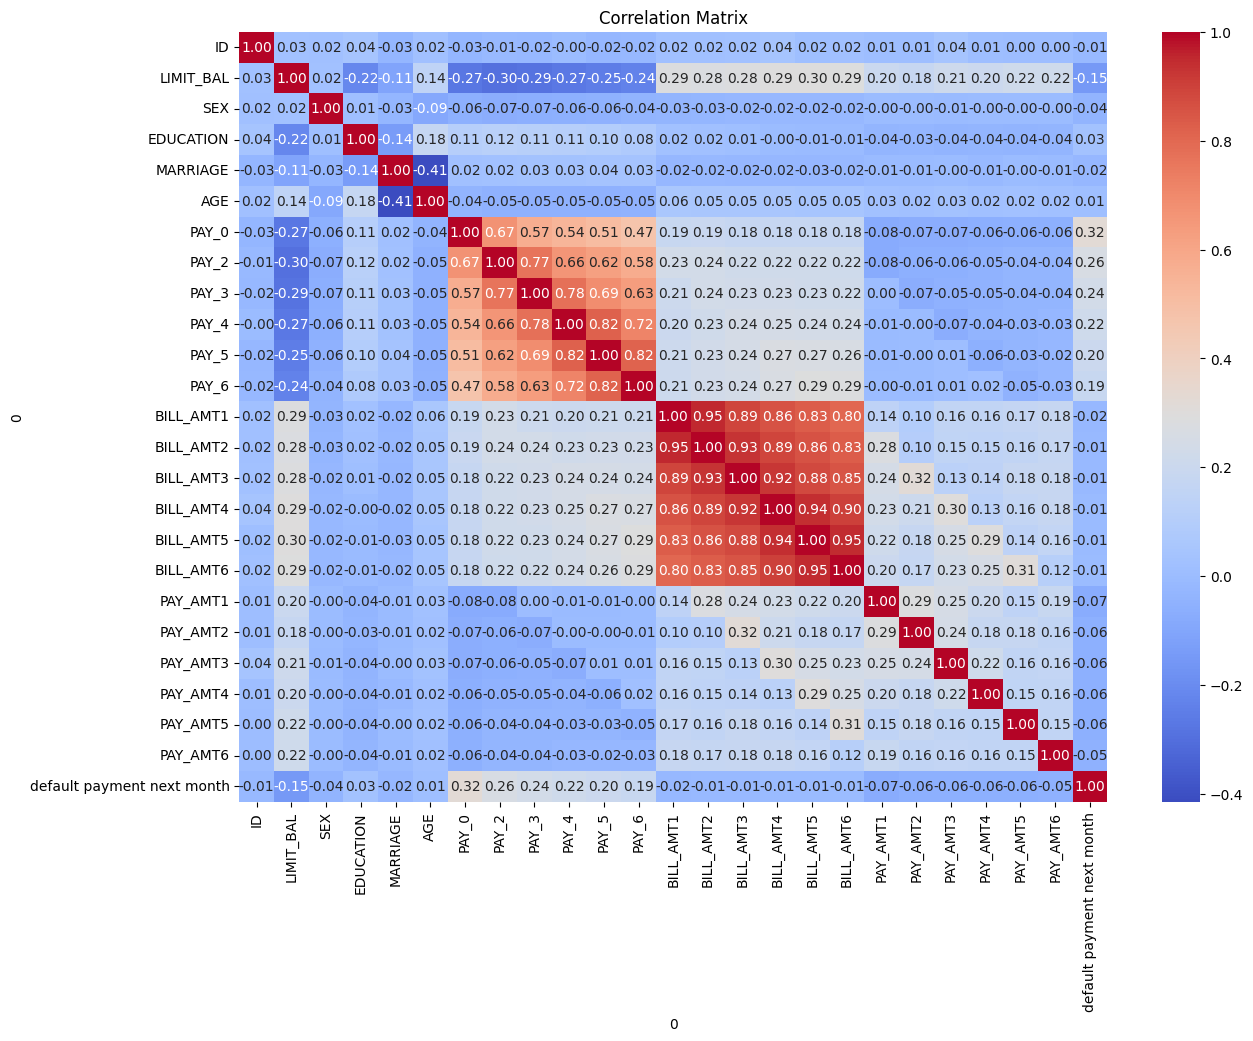

In [15]:
# correlation matrix
plt.figure(figsize=(14, 10))
correlation_matrix = credit_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


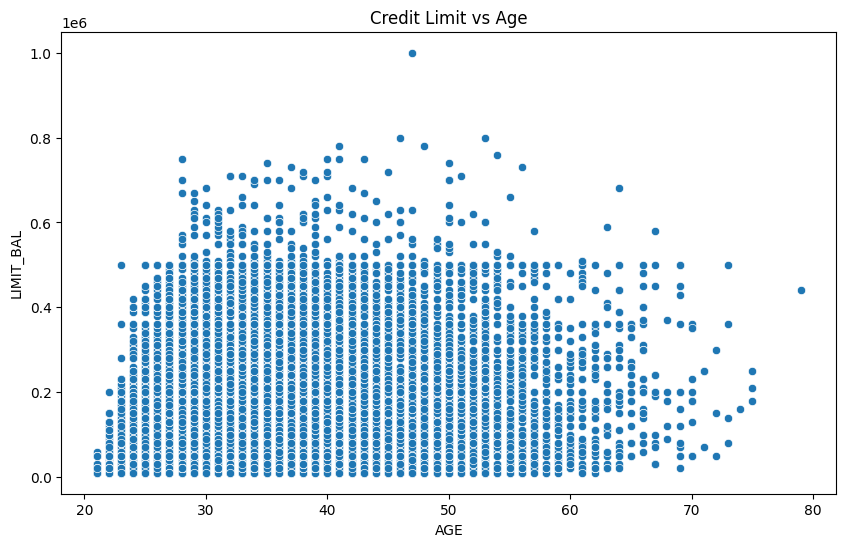

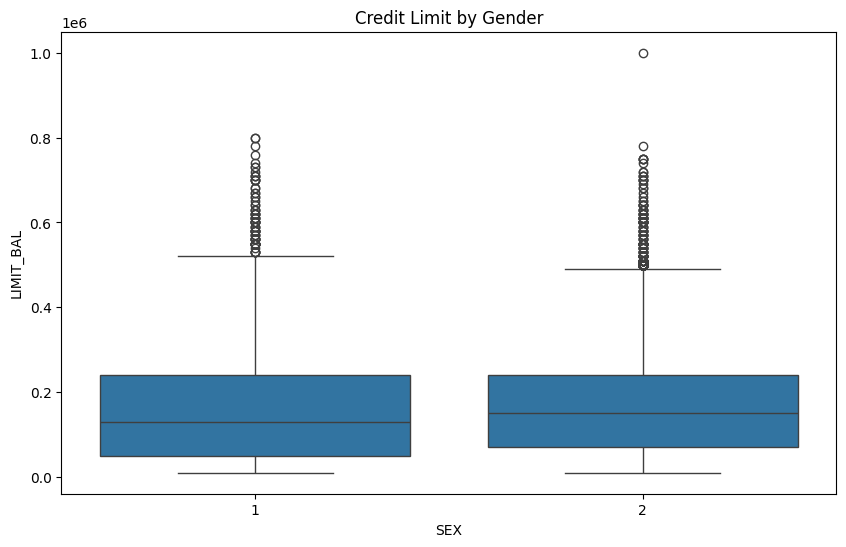

In [16]:
# Scatter plot for LIMIT_BAL vs AGE
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AGE', y='LIMIT_BAL', data=credit_data)
plt.title('Credit Limit vs Age')
plt.show()

# Box plot for LIMIT_BAL by SEX
plt.figure(figsize=(10, 6))
sns.boxplot(x='SEX', y='LIMIT_BAL', data=credit_data)
plt.title('Credit Limit by Gender')
plt.show()


In [17]:
# Summary statistics for payment history columns
pay_columns = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
print(credit_data[pay_columns].describe())


0       PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6
count   30000  30000  30000  30000  30000  30000
unique     11     11     11     11     10     10
top         0      0      0      0      0      0
freq    14737  15730  15764  16455  16947  16286


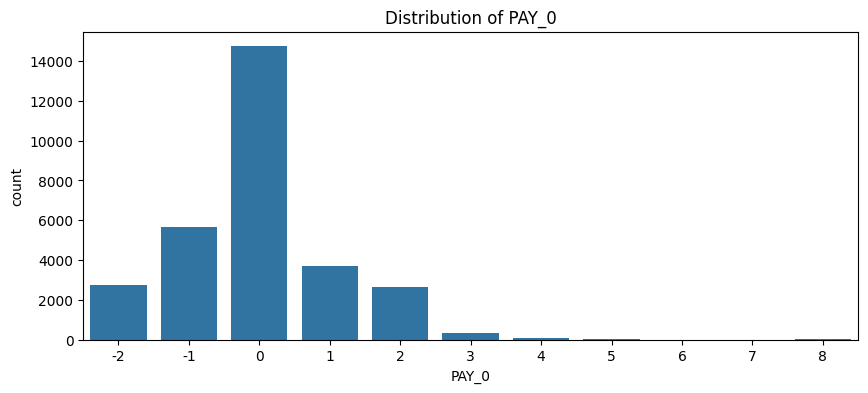

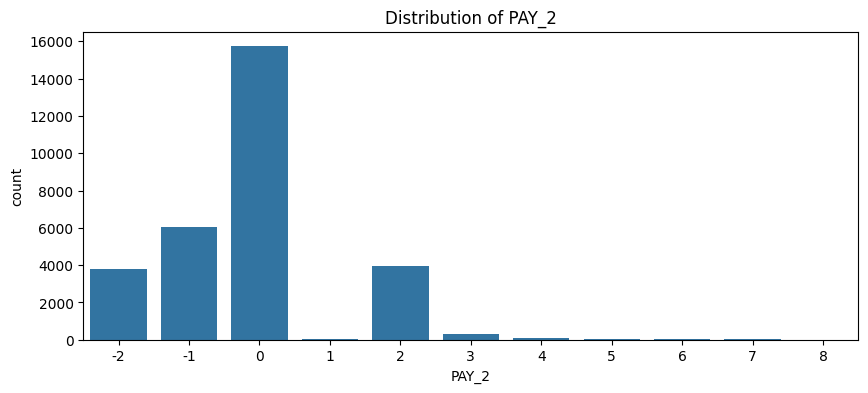

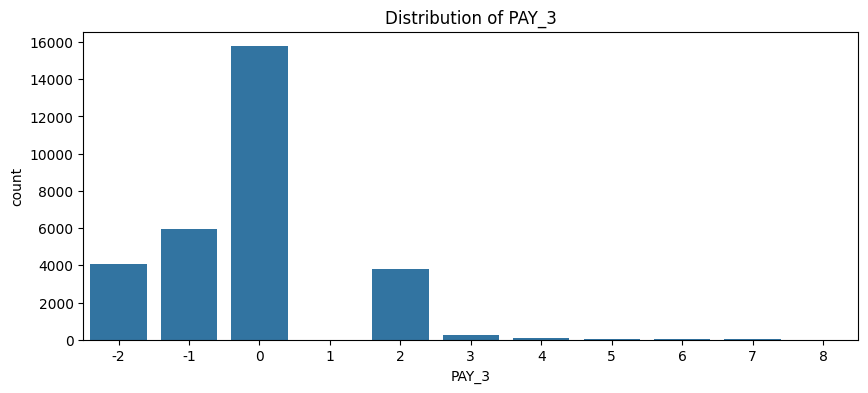

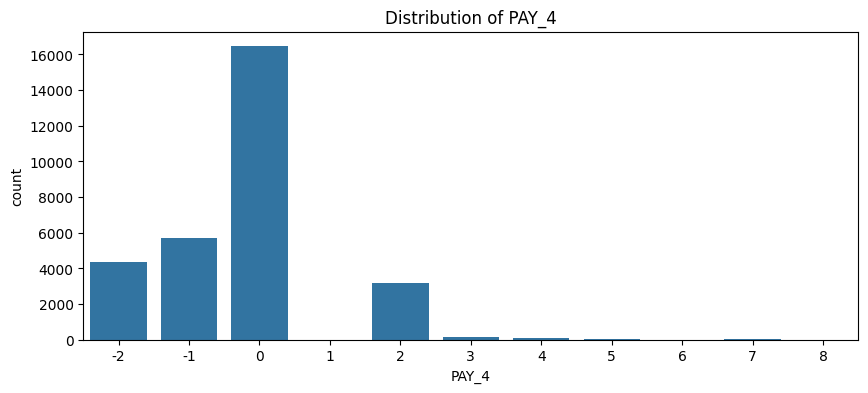

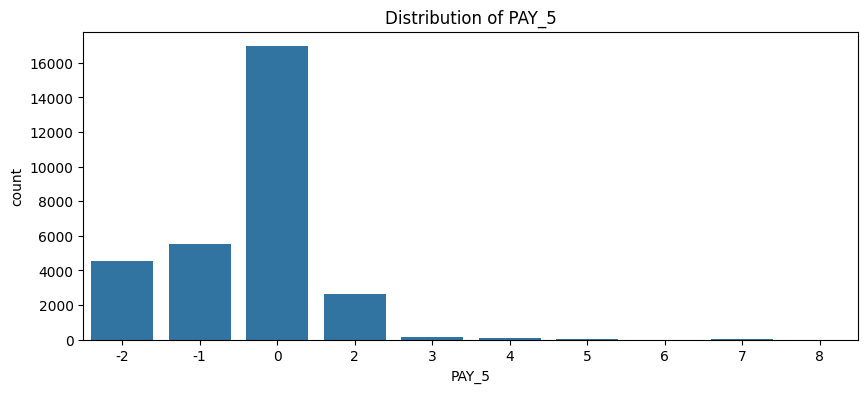

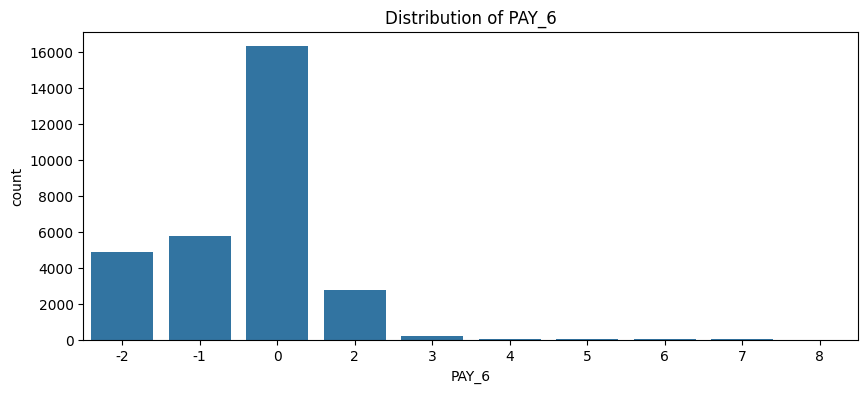

In [18]:
# Plotting the distribution of payment history columns
for col in pay_columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=col, data=credit_data)
    plt.title(f'Distribution of {col}')
    plt.show()


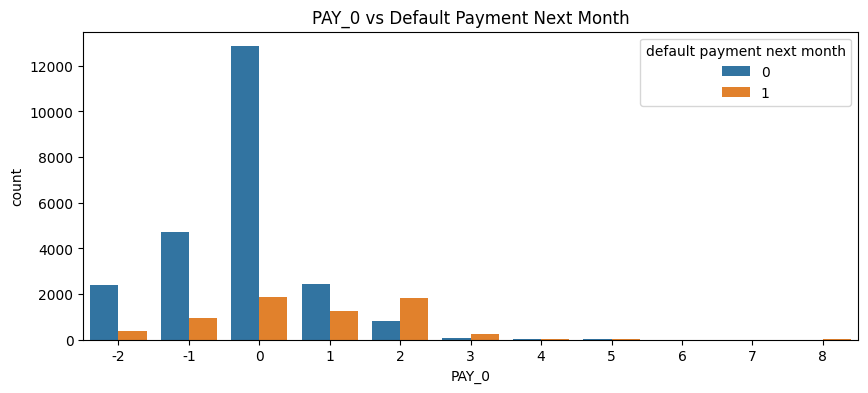

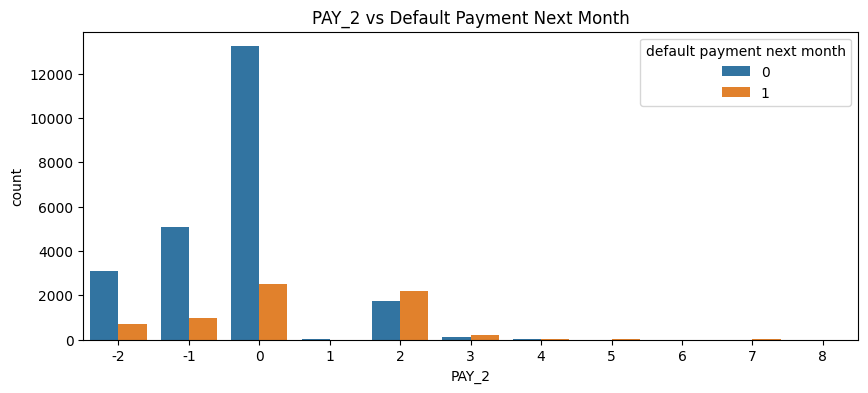

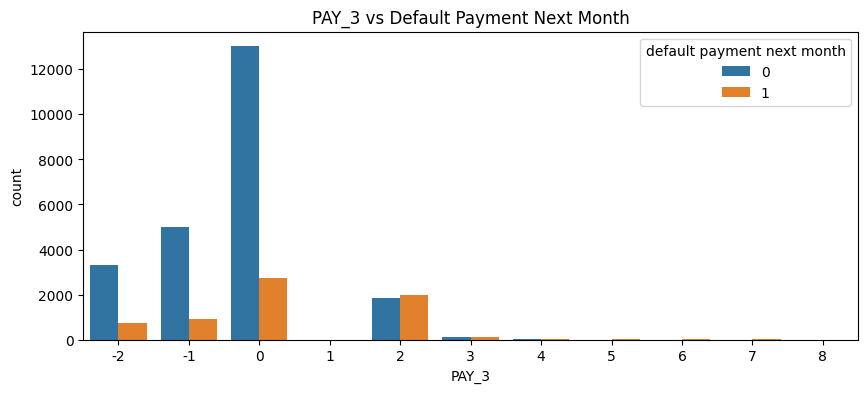

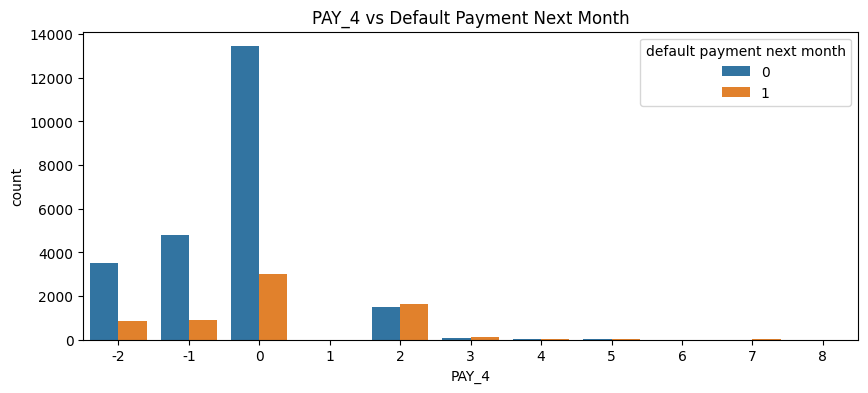

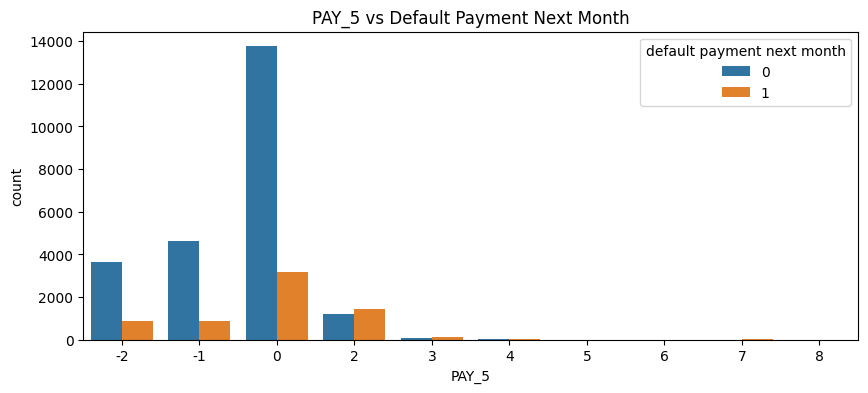

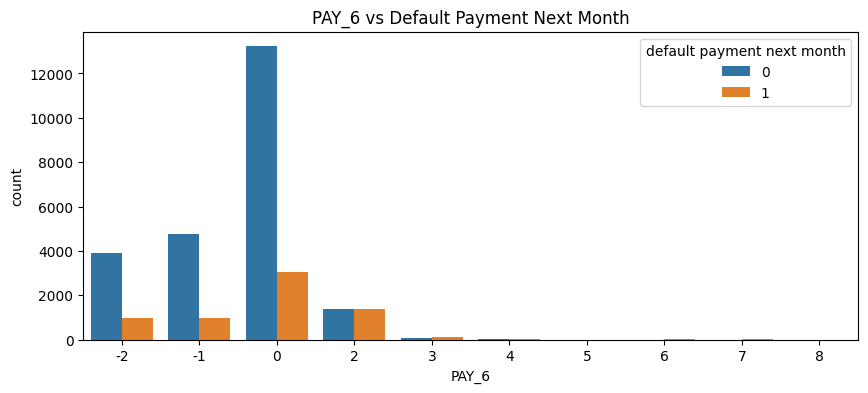

In [19]:
# Analyzing the relationship between payment history and default
for col in pay_columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=col, hue='default payment next month', data=credit_data)
    plt.title(f'{col} vs Default Payment Next Month')
    plt.show()


# **Data** **Preprocessing**

In [20]:
# Feature Scaling
# Extract features and target variable
X = credit_data.drop(columns=['default payment next month'])
y = credit_data['default payment next month']

# Ensure the target variable is numeric
y = y.astype(int)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

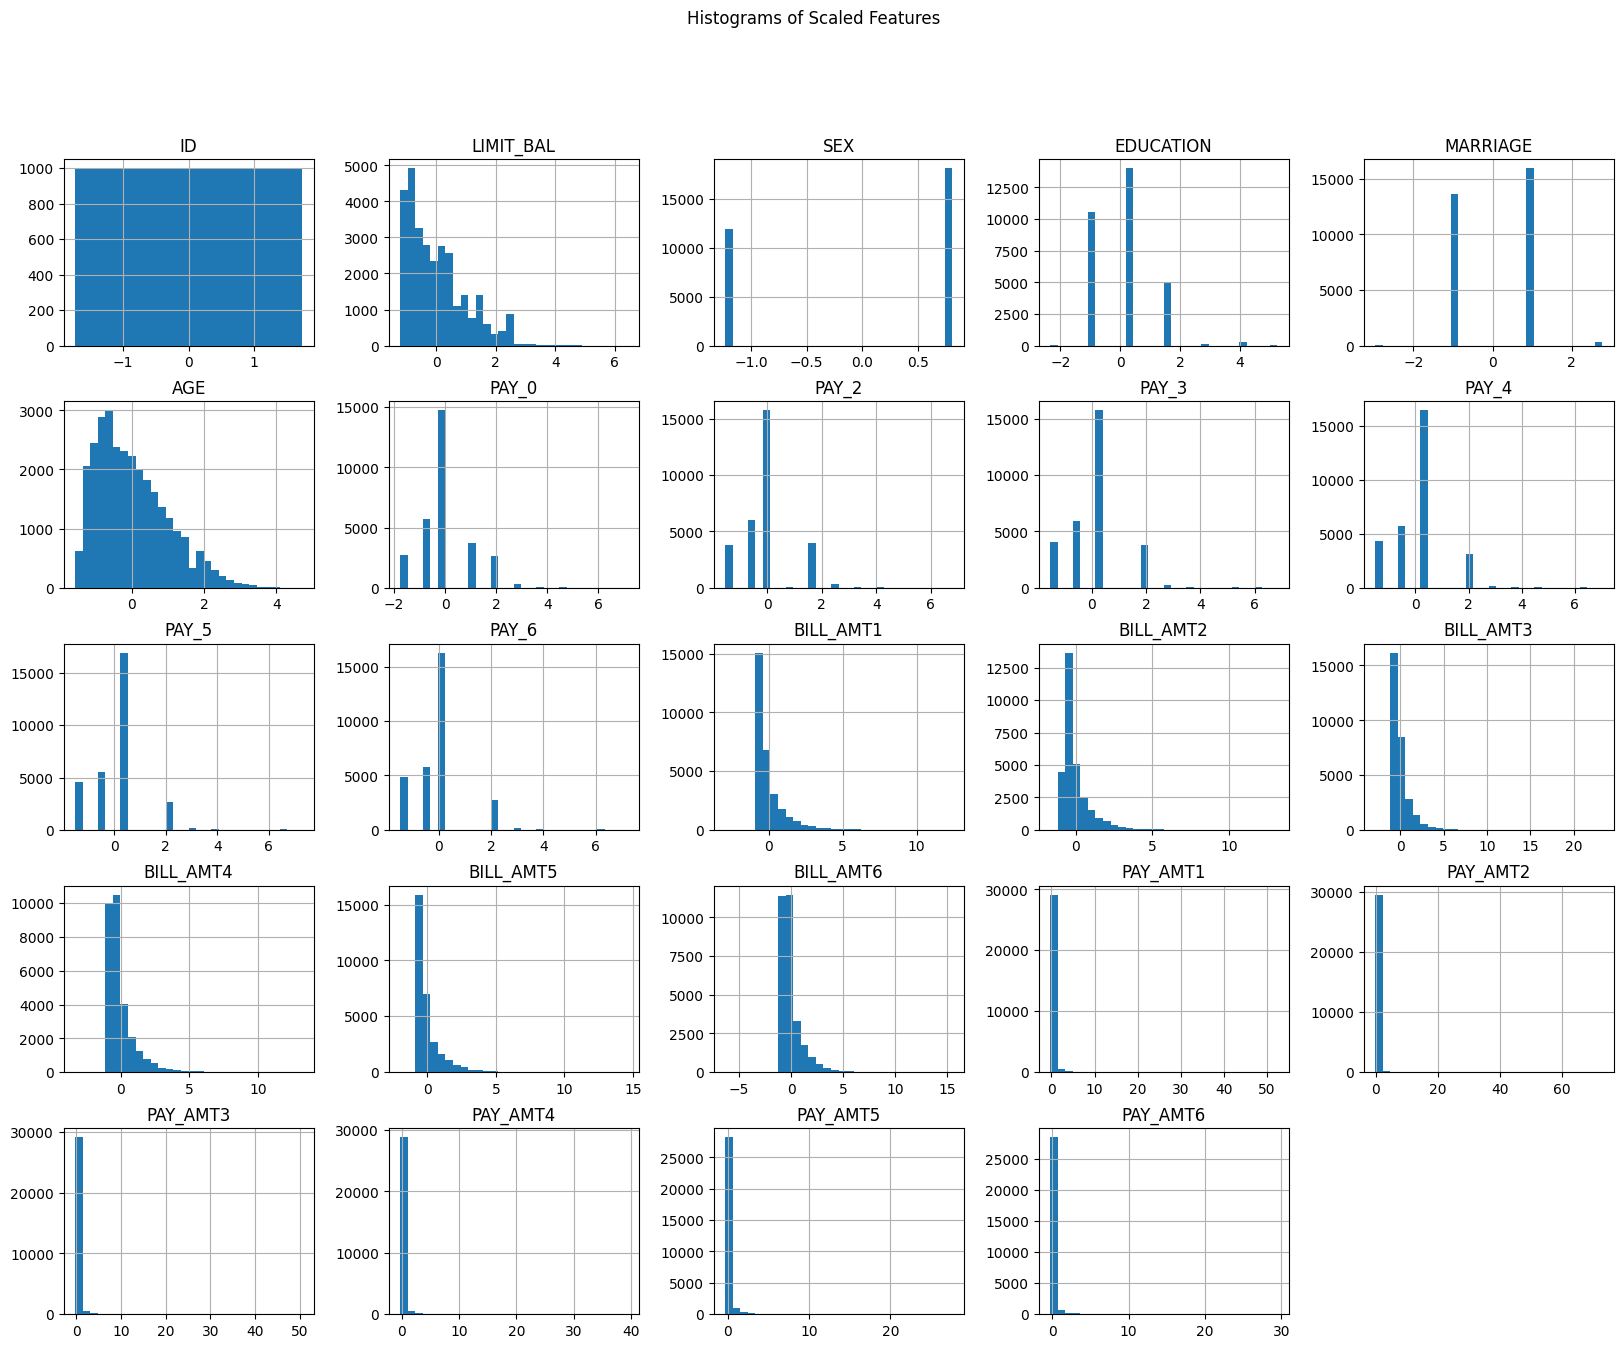

In [21]:
# Convert the scaled data back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Plot histograms of the scaled features
X_scaled_df.hist(bins=30, figsize=(20, 15))
plt.suptitle("Histograms of Scaled Features")
plt.show()

In [22]:
#Addressing Class Imbalance
# Check class distribution
print(y.value_counts())

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)


default payment next month
0    23364
1     6636
Name: count, dtype: int64


In [23]:
# Check the class distribution of y_res after SMOTE
print(pd.Series(y_res).value_counts())

default payment next month
1    23364
0    23364
Name: count, dtype: int64


In [24]:
# display first few rows
X_scaled_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-1.731993,-1.136720,0.810161,0.185828,-1.057295,-1.246020,1.794564,1.782348,-0.696663,-0.666599,...,-0.667993,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382
1,-1.731878,-0.365981,0.810161,0.185828,0.858557,-1.029047,-0.874991,1.782348,0.138865,0.188746,...,-0.639254,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878
2,-1.731762,-0.597202,0.810161,0.185828,0.858557,-0.161156,0.014861,0.111736,0.138865,0.188746,...,-0.482408,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122
3,-1.731647,-0.905498,0.810161,0.185828,-1.057295,0.164303,0.014861,0.111736,0.138865,0.188746,...,0.032846,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130
4,-1.731531,-0.905498,-1.234323,0.185828,-1.057295,2.334029,-0.874991,0.111736,-0.696663,0.188746,...,-0.161189,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187


In [25]:
# add target variable
X_scaled_df['default payment next month'] = credit_data['default payment next month']
X_scaled_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,-1.731993,-1.136720,0.810161,0.185828,-1.057295,-1.246020,1.794564,1.782348,-0.696663,-0.666599,...,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382,1
1,-1.731878,-0.365981,0.810161,0.185828,0.858557,-1.029047,-0.874991,1.782348,0.138865,0.188746,...,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878,1
2,-1.731762,-0.597202,0.810161,0.185828,0.858557,-0.161156,0.014861,0.111736,0.138865,0.188746,...,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122,0
3,-1.731647,-0.905498,0.810161,0.185828,-1.057295,0.164303,0.014861,0.111736,0.138865,0.188746,...,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130,0
4,-1.731531,-0.905498,-1.234323,0.185828,-1.057295,2.334029,-0.874991,0.111736,-0.696663,0.188746,...,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187,0


# **Model** **Training**

In [26]:
# Define X, y
X = X_scaled_df.drop('default payment next month', axis=1).values
y = X_scaled_df['default payment next month'].values

# Check the unique values and data type of y
print(f"Unique values in y: {np.unique(y)}")
print(f"Data type of y: {type(y[0])}")

# Encode the target variable
if not np.issubdtype(y.dtype, np.number):
    le = LabelEncoder()
    y = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Unique values in y: [0 1]
Data type of y: <class 'int'>


In [27]:
# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions with Random Forest
rf_y_pred = rf_model.predict(X_test)

# Evaluate the Random Forest model
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_report = classification_report(y_test, rf_y_pred)

print("Random Forest Classifier:")
print(f"Accuracy: {rf_accuracy:.4f}")
print("Classification Report:")
print(rf_report)

Random Forest Classifier:
Accuracy: 0.8135
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4687
           1       0.63      0.36      0.46      1313

    accuracy                           0.81      6000
   macro avg       0.73      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000



In [28]:
# Define parameter grid to search through
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)

# Start the timer before fitting
start_time = time.time()

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# End the timer after fitting
end_time = time.time()

# Calculate the time taken
tuning_time = end_time - start_time
print(f"Time taken for hyperparameter tuning and model fitting: {tuning_time:.2f} seconds")

# Extract the best parameters and train a new model with these parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Create a new Random Forest model with the best parameters
rf_best_model = RandomForestClassifier(**best_params, random_state=42)
rf_best_model.fit(X_train, y_train)

# Make predictions with the optimized Random Forest model
rf_y_pred_best = rf_best_model.predict(X_test)

# Evaluate the optimized Random Forest model
rf_best_accuracy = accuracy_score(y_test, rf_y_pred_best)
rf_best_report = classification_report(y_test, rf_y_pred_best)

print("Optimized Random Forest Classifier:")
print(f"Accuracy: {rf_best_accuracy:.4f}")
print("Classification Report:")
print(rf_best_report)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Time taken for hyperparameter tuning and model fitting: 93.40 seconds
Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Optimized Random Forest Classifier:
Accuracy: 0.8213
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.67      0.36      0.47      1313

    accuracy                           0.82      6000
   macro avg       0.76      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000



In [29]:
# Create and train the XGBoost model
xg_model = XGBClassifier(n_estimators=100, random_state=42)
xg_model.fit(X_train, y_train)

# Make predictions with  XGBoost
xg_y_pred = xg_model.predict(X_test)

# Evaluate the  XGBoost model
xg_accuracy = accuracy_score(y_test, xg_y_pred)
xg_report = classification_report(y_test, xg_y_pred)

print("XGBoost Classifier:")
print(f"Accuracy: {xg_accuracy:.4f}")
print("Classification Report:")
print(xg_report)

XGBoost Classifier:
Accuracy: 0.8158
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4687
           1       0.64      0.36      0.46      1313

    accuracy                           0.82      6000
   macro avg       0.74      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000



In [30]:
# Define the parameter grid to search through
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=xg_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)

# Start the timer before fitting
start_time = time.time()

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# End the timer after fitting
end_time = time.time()

# Calculate the time taken
tuning_time = end_time - start_time
print(f"Time taken for hyperparameter tuning and model fitting: {tuning_time:.2f} seconds")

# Extract the best parameters and train a new model with these parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Create a new XGBoost model with the best parameters
xg_best_model = XGBClassifier(**best_params, random_state=42)
xg_best_model.fit(X_train, y_train)

# Make predictions with the optimized XGBoost model
xg_y_pred_best = xg_best_model.predict(X_test)

# Evaluate the optimized XGBoost model
xg_best_accuracy = accuracy_score(y_test, xg_y_pred_best)
xg_best_report = classification_report(y_test, xg_y_pred_best)

print("Optimized XGBoost Classifier:")
print(f"Accuracy: {xg_best_accuracy:.4f}")
print("Classification Report:")
print(xg_best_report)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:07:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


Time taken for hyperparameter tuning and model fitting: 21.39 seconds
Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
Optimized XGBoost Classifier:
Accuracy: 0.8230
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.67      0.37      0.48      1313

    accuracy                           0.82      6000
   macro avg       0.76      0.66      0.69      6000
weighted avg       0.81      0.82      0.80      6000



In [31]:
# Create and train the AdaBoost model
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(X_train, y_train)

# Make predictions with AdaBoost
ada_y_pred = ada_model.predict(X_test)

# Evaluate the AdaBoost model
ada_accuracy = accuracy_score(y_test, ada_y_pred)
ada_report = classification_report(y_test, ada_y_pred)

print("AdaBoost Classifier:")
print(f"Accuracy: {ada_accuracy:.4f}")
print("Classification Report:")
print(ada_report)

AdaBoost Classifier:
Accuracy: 0.8173
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4687
           1       0.67      0.32      0.43      1313

    accuracy                           0.82      6000
   macro avg       0.75      0.64      0.66      6000
weighted avg       0.80      0.82      0.79      6000



In [32]:
# Define the parameter grid to search through
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'algorithm': ['SAMME', 'SAMME.R']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=ada_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)

# Start the timer before fitting
start_time = time.time()

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# End the timer after fitting
end_time = time.time()

# Calculate the time taken
tuning_time = end_time - start_time
print(f"Time taken for hyperparameter tuning and model fitting: {tuning_time:.2f} seconds")

# Extract the best parameters and train a new model with these parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Create a new AdaBoost model with the best parameters
ada_best_model = AdaBoostClassifier(**best_params, random_state=42)
ada_best_model.fit(X_train, y_train)

# Make predictions with the optimized AdaBoost model
ada_y_pred_best = ada_best_model.predict(X_test)

# Evaluate the optimized AdaBoost model
ada_best_accuracy = accuracy_score(y_test, ada_y_pred_best)
ada_best_report = classification_report(y_test, ada_y_pred_best)

print("Optimized AdaBoost Classifier:")
print(f"Accuracy: {ada_best_accuracy:.4f}")
print("Classification Report:")
print(ada_best_report)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Time taken for hyperparameter tuning and model fitting: 54.04 seconds
Best Parameters: {'algorithm': 'SAMME', 'learning_rate': 0.01, 'n_estimators': 50}
Optimized AdaBoost Classifier:
Accuracy: 0.8193
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4687
           1       0.69      0.32      0.44      1313

    accuracy                           0.82      6000
   macro avg       0.76      0.64      0.66      6000
weighted avg       0.80      0.82      0.79      6000



In [33]:
# Create and train the CatBoost model
cat_model = CatBoostClassifier(n_estimators=100, random_state=42)
cat_model.fit(X_train, y_train)

# Make predictions with CatBoost
cat_y_pred = cat_model.predict(X_test)

# Evaluate the CatBoost model
cat_accuracy = accuracy_score(y_test, cat_y_pred)
cat_report = classification_report(y_test, cat_y_pred)

print("CatBoost Classifier:")
print(f"Accuracy: {cat_accuracy:.4f}")
print("Classification Report:")
print(cat_report)


Learning rate set to 0.330586
0:	learn: 0.5400835	total: 60.2ms	remaining: 5.96s
1:	learn: 0.4795627	total: 71.2ms	remaining: 3.49s
2:	learn: 0.4529278	total: 81.3ms	remaining: 2.63s
3:	learn: 0.4398475	total: 91.2ms	remaining: 2.19s
4:	learn: 0.4330176	total: 100ms	remaining: 1.91s
5:	learn: 0.4299314	total: 109ms	remaining: 1.71s
6:	learn: 0.4269741	total: 118ms	remaining: 1.57s
7:	learn: 0.4253439	total: 127ms	remaining: 1.46s
8:	learn: 0.4236067	total: 136ms	remaining: 1.37s
9:	learn: 0.4224759	total: 145ms	remaining: 1.3s
10:	learn: 0.4213909	total: 153ms	remaining: 1.24s
11:	learn: 0.4194002	total: 162ms	remaining: 1.19s
12:	learn: 0.4181256	total: 171ms	remaining: 1.14s
13:	learn: 0.4172865	total: 179ms	remaining: 1.1s
14:	learn: 0.4160943	total: 188ms	remaining: 1.06s
15:	learn: 0.4154317	total: 199ms	remaining: 1.05s
16:	learn: 0.4142630	total: 208ms	remaining: 1.01s
17:	learn: 0.4138493	total: 217ms	remaining: 988ms
18:	learn: 0.4134202	total: 225ms	remaining: 958ms
19:	learn

In [36]:
# Define the parameter grid to search through
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=cat_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)

# Start the timer before fitting
start_time = time.time()

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# End the timer after fitting
end_time = time.time()

# Calculate the time taken
tuning_time = end_time - start_time
print(f"Time taken for hyperparameter tuning and model fitting: {tuning_time:.2f} seconds")

# Extract the best parameters and train a new model with these parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Create a new CatBoost model with the best parameters
cat_best_model = CatBoostClassifier(**best_params, random_state=42, silent=True)
cat_best_model.fit(X_train, y_train)

# Make predictions with the optimized CatBoost model
cat_y_pred_best = cat_best_model.predict(X_test)

# Evaluate the optimized CatBoost model
cat_best_accuracy = accuracy_score(y_test, cat_y_pred_best)
cat_best_report = classification_report(y_test, cat_y_pred_best)

print("Optimized CatBoost Classifier:")
print(f"Accuracy: {cat_best_accuracy:.4f}")
print("Classification Report:")
print(cat_best_report)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
0:	learn: 0.6380800	total: 29.5ms	remaining: 1.45s
1:	learn: 0.5961574	total: 52ms	remaining: 1.25s
2:	learn: 0.5627993	total: 70.8ms	remaining: 1.11s
3:	learn: 0.5370244	total: 90.6ms	remaining: 1.04s
4:	learn: 0.5154289	total: 111ms	remaining: 996ms
5:	learn: 0.4991906	total: 132ms	remaining: 968ms
6:	learn: 0.4855363	total: 157ms	remaining: 964ms
7:	learn: 0.4750330	total: 176ms	remaining: 922ms
8:	learn: 0.4664735	total: 195ms	remaining: 889ms
9:	learn: 0.4596355	total: 216ms	remaining: 863ms
10:	learn: 0.4538250	total: 241ms	remaining: 854ms
11:	learn: 0.4487552	total: 259ms	remaining: 820ms
12:	learn: 0.4450664	total: 286ms	remaining: 815ms
13:	learn: 0.4417703	total: 303ms	remaining: 779ms
14:	learn: 0.4395404	total: 316ms	remaining: 738ms
15:	learn: 0.4372924	total: 329ms	remaining: 699ms
16:	learn: 0.4354244	total: 353ms	remaining: 686ms
17:	learn: 0.4337453	total: 375ms	remaining: 666ms
18:	learn: 0.4323557	total: 39

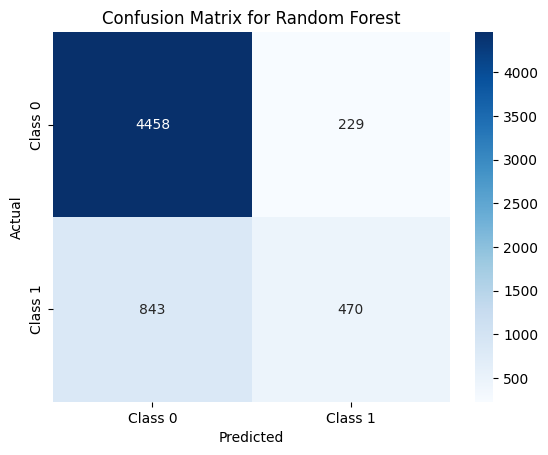

In [37]:
# Random Forest
conf_matrix = confusion_matrix(y_test, rf_y_pred_best)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()


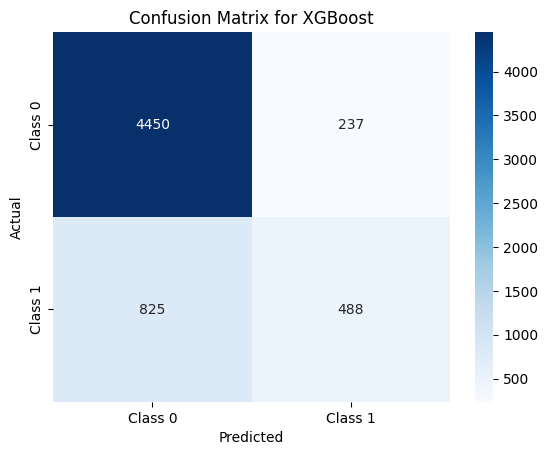

In [38]:
# XGBoost
conf_matrix = confusion_matrix(y_test, xg_y_pred_best)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for XGBoost')
plt.show()


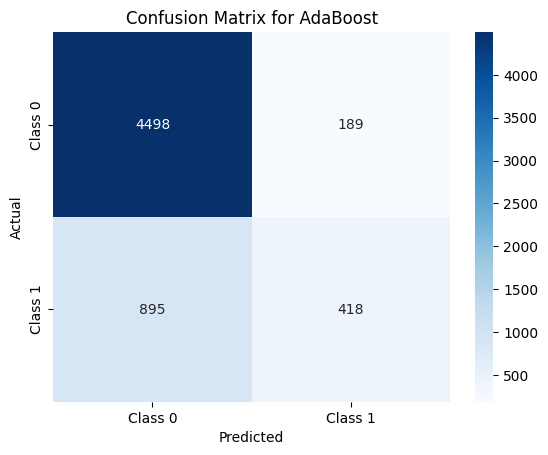

In [39]:
# AdaBoost
conf_matrix = confusion_matrix(y_test, ada_y_pred_best)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for AdaBoost')
plt.show()


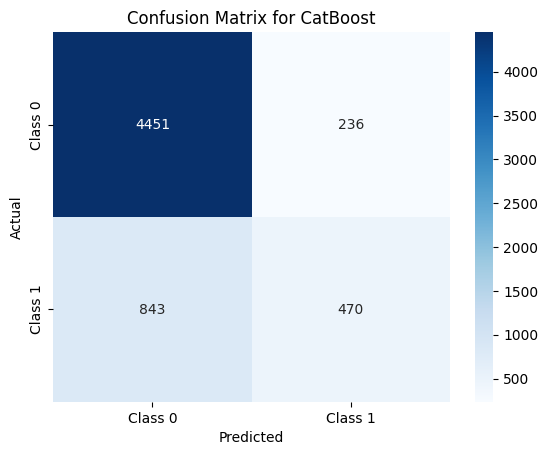

In [40]:
# CatBoost
conf_matrix = confusion_matrix(y_test, cat_y_pred_best)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for CatBoost')
plt.show()


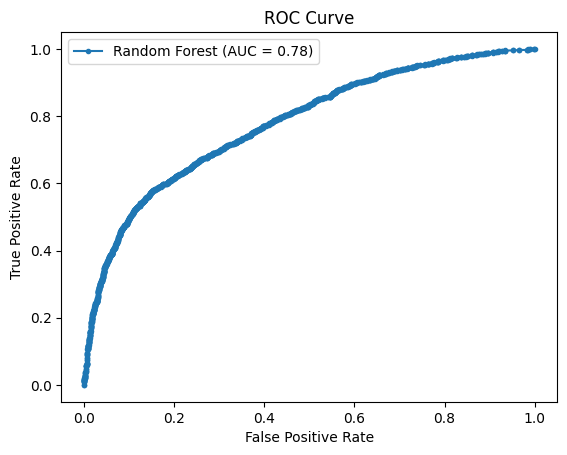

In [41]:
# Random Forest
y_pred_proba = rf_best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, marker='.', label=f'Random Forest (AUC = {auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()



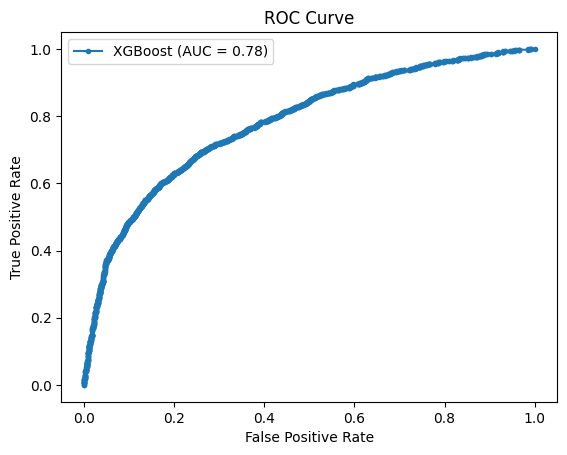

In [42]:
# XGBoost
y_pred_proba = xg_best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, marker='.', label=f'XGBoost (AUC = {auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


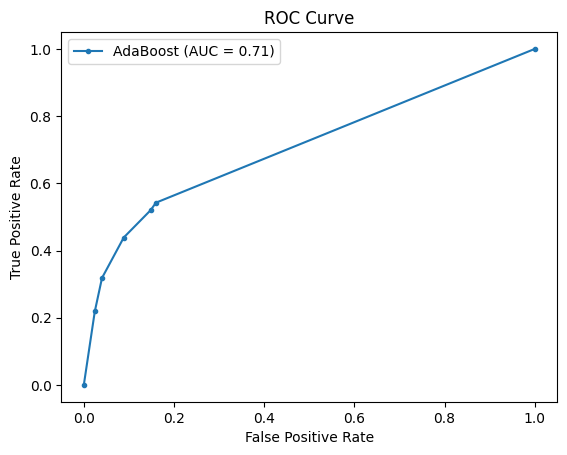

In [43]:
#  AdaBoost
y_pred_proba = ada_best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, marker='.', label=f'AdaBoost (AUC = {auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


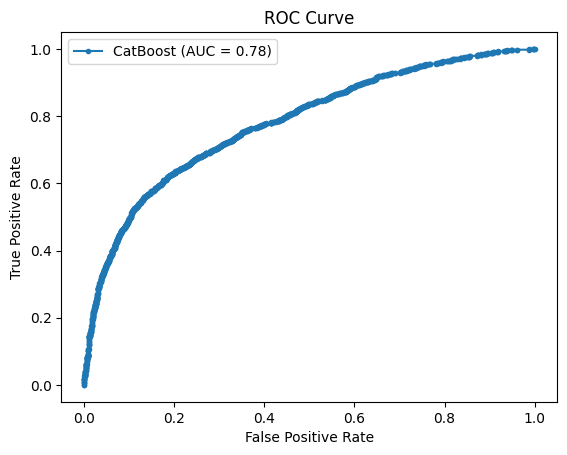

In [44]:
# CatBoost
y_pred_proba = cat_best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, marker='.', label=f'CatBoost (AUC = {auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


In [45]:
# Random Forest feature importance
rf_importances = rf_best_model.feature_importances_
print(rf_importances)

[0.03013537 0.03431357 0.00355694 0.00845965 0.00499865 0.02490835
 0.23200406 0.1158989  0.08090514 0.04626223 0.04416421 0.02984134
 0.03375424 0.02948205 0.02780724 0.0264866  0.02604833 0.02673551
 0.03861757 0.02820818 0.03217829 0.02694472 0.02294132 0.02534756]


In [46]:
# XGBoost feature importance
xg_importances = xg_best_model.feature_importances_
print(xg_importances)

[0.01177859 0.02202823 0.01452299 0.01578123 0.01331831 0.01255236
 0.44176516 0.11855844 0.06111544 0.03822177 0.03481282 0.03241593
 0.01729647 0.01659778 0.01361584 0.01212767 0.01290939 0.0127509
 0.01819926 0.01695462 0.02074863 0.01420314 0.01300958 0.01471544]


In [47]:
# AdaBoost feature importance
ada_importances = ada_best_model.feature_importances_
print(ada_importances)

[0.         0.         0.         0.         0.         0.
 0.96482213 0.03517787 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


In [48]:
# CatBoost feature importance
cat_importances = cat_best_model.feature_importances_
print(cat_importances)

[ 2.34484156  7.6379741   1.35919366  2.85100555  1.61934009  1.97745395
 31.89370223  7.10843407  3.9563111   4.3701875   2.31871339  3.0388495
  4.71200182  2.88550428  1.82815346  0.99266362  1.30833861  1.15321374
  3.32464833  3.76617023  3.36197612  3.21525583  0.95771449  2.01835278]


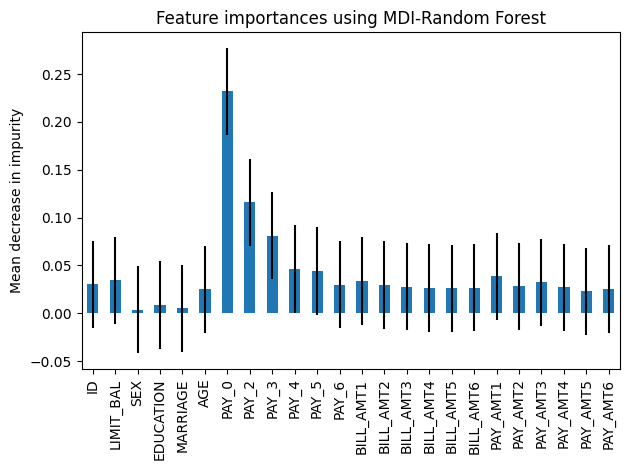

In [49]:
# list of features
feature_names = ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Convert list of importances to numpy array
importances_array = np.array(rf_importances)
std = np.std(importances_array, axis=0)
forest_importances = pd.Series(rf_importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI-Random Forest")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

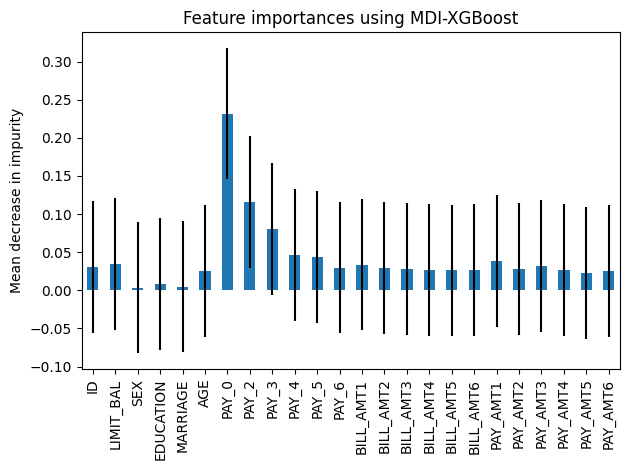

In [50]:
# list of features
feature_names = ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Convert list of importances to numpy array
importances_array = np.array(xg_importances)
std = np.std(importances_array, axis=0)
forest_importances = pd.Series(rf_importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI-XGBoost")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

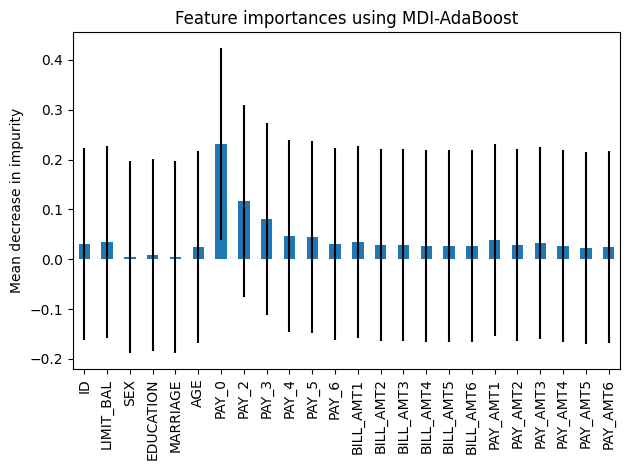

In [51]:
# list of features
feature_names = ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Convert list of importances to numpy array
importances_array = np.array(ada_importances)
std = np.std(importances_array, axis=0)
forest_importances = pd.Series(rf_importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI-AdaBoost")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

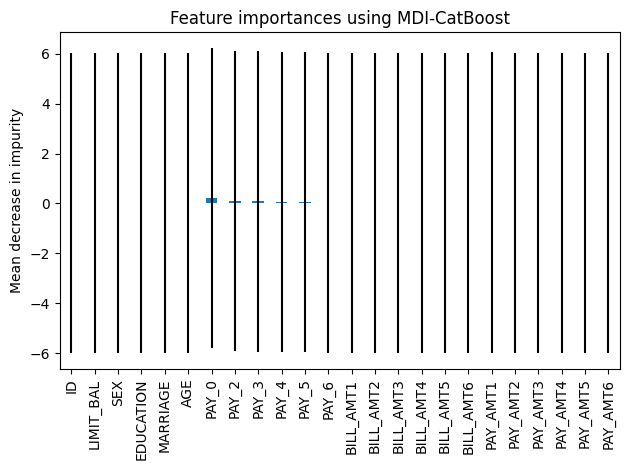

In [52]:
# list of features
feature_names = ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Convert list of importances to numpy array
importances_array = np.array(cat_importances)
std = np.std(importances_array, axis=0)
forest_importances = pd.Series(rf_importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI-CatBoost")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()